In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import gc

from PIL import Image

from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple

from transformers import AutoTokenizer, AutoFeatureExtractor, AutoModel
from datasets import load_dataset, set_caching_enabled
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import nltk

nltk.data.path.append("./Checkpoints/")

from nltk.corpus import wordnet
import gc

c:\Users\rlsha\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# Additional Info when using cuda
if device.type == "cuda":
    print(torch.cuda.get_device_name(0))

cuda
NVIDIA GeForce RTX 3050 Laptop GPU


# Load data

In [3]:
# load dataset from CSV files for training and testing
dataset = load_dataset(
    "csv",
    data_files={
        # NOTE: change paths when running locally
        "train": "./vqa-dataset-csvs/data_train.csv",
        "test": "./vqa-dataset-csvs/data_eval.csv",
    },
)

# read answer space from file and split into an array by line
# NOTE: change paths when running locally
with open("./vqa-dataset-csvs/answer_space.txt") as f:
    answer_space = f.read().splitlines()

# label each item in the dataset with their respective answers
dataset = dataset.map(
    lambda examples: {
        "label": [
            answer_space.index(
                ans.replace(" ", "").split(",")[0]
            )  # select the 1st answer if multiple answers are provided
            for ans in examples["answer"]
        ]
    },
    batched=True,
)

# Helper functions

## show_example image

./vqa-dataset-images/images/24980.jpg


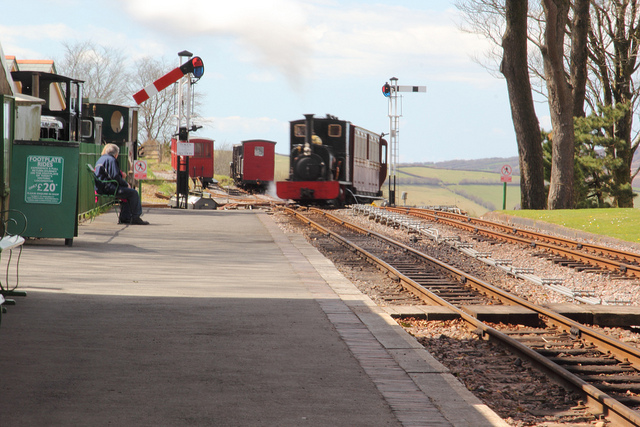

Question:	 Is there more then 2 people here?
Answer:		 no (Label: 744)


'no'

In [4]:
import IPython.display as display


def show_example(train=True, idx=None):
    dataset_type = "train" if train else "test"
    data = dataset[dataset_type]

    if idx is None:
        idx = np.random.randint(len(data))

    image_path = (
        "./vqa-dataset-images/images/" + f"{data[idx]['image_id']}.jpg"
    )
    print(image_path)
    image = Image.open(image_path)
    display.display(image)

    question = data[idx]["question"]
    answer = data[idx]["answer"]
    label = data[idx]["label"]

    print(f"Question:\t {question}")
    print(f"Answer:\t\t {answer} (Label: {label})")

    return answer


show_example()

## Calculate similarity between two answers using wup similarity

In [5]:
def wup_measure(a, b, similarity_threshold=0.925):
    """
    Computes the Wu-Palmer similarity score between two words or phrases.

    Args:
        a (str): First word or phrase.
        b (str): Second word or phrase.
        similarity_threshold (float): Threshold for similarity to consider semantic fields.

    Returns:
        float: Wu-Palmer similarity score.
    """

    def get_semantic_field(word):
        """
        Retrieves the semantic field for a word.

        Args:
            word (str): Word to retrieve the semantic field for.

        Returns:
            Tuple: Tuple containing the semantic field and weight.
        """
        weight = 1.0
        semantic_field = wordnet.synsets(word, pos=wordnet.NOUN)
        return semantic_field, weight

    def get_stem_word(word):
        """
        Processes words in the form 'word\d+:wordid' by returning the word and downweighting.

        Args:
            word (str): Word to process.

        Returns:
            Tuple: Tuple containing the processed word and weight.
        """
        weight = 1.0
        return word, weight

    global_weight = 1.0

    # Get stem words and weights
    a, global_weight_a = get_stem_word(a)
    b, global_weight_b = get_stem_word(b)
    global_weight = min(global_weight_a, global_weight_b)

    # Check if words are the same
    if a == b:
        return 1.0 * global_weight

    # Check for empty strings
    if a == "" or b == "":
        return 0

    # Get semantic fields and weights
    interp_a, weight_a = get_semantic_field(a)
    interp_b, weight_b = get_semantic_field(b)

    # Check for empty semantic fields
    if interp_a == [] or interp_b == []:
        return 0

    # Find the most optimistic interpretation
    global_max = 0.0
    for x in interp_a:
        for y in interp_b:
            local_score = x.wup_similarity(y)
            if local_score > global_max:
                global_max = local_score

    # Use semantic fields and downweight unless the score is high (indicating synonyms)
    if global_max < similarity_threshold:
        interp_weight = 0.1
    else:
        interp_weight = 1.0

    final_score = global_max * weight_a * weight_b * interp_weight * global_weight
    return final_score


def batch_wup_measure(labels, preds):
    """
    Computes the average Wu-Palmer similarity score for a batch of predicted and ground truth labels.

    Args:
        labels (List): List of ground truth labels.
        preds (List): List of predicted labels.

    Returns:
        float: Average Wu-Palmer similarity score for the batch.
    """
    wup_scores = [
        wup_measure(answer_space[label], answer_space[pred])
        for label, pred in zip(labels, preds)
    ]
    return np.mean(wup_scores)

## `compute_metrics` reports metrics for the given batch of logits & labels

Metrics include:
- Accuracy
- Precision
- Recall
- F1
- Wup Similarity

In [6]:
def compute_metrics(eval_tuple: Tuple[np.ndarray, np.ndarray]) -> Dict[str, float]:
    """
    Computes evaluation metrics for a given set of logits and labels.

    Args:
        eval_tuple (Tuple): Tuple containing logits and corresponding ground truth labels.

    Returns:
        Dict: Dictionary of computed metrics, including WUP similarity, accuracy, and F1 score.
    """
    logits, labels = eval_tuple

    # Calculate predictions
    preds = logits.argmax(axis=-1)

    # Compute metrics
    metrics = {
        "wups": batch_wup_measure(labels, preds),
        "acc": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="macro"),
        "precision": precision_score(labels, preds, average="macro"),
        "recall": recall_score(labels, preds, average="macro"),
    }

    return metrics

# Model Classes

In [7]:
@dataclass
class MultimodalCollator:
    tokenizer: AutoTokenizer
    preprocessor: AutoFeatureExtractor

    def tokenize_text(self, texts: List[str]) -> Dict[str, torch.Tensor]:
        """
        Tokenize text inputs and return relevant tokenized information.
        """
        encoded_text = self.tokenizer(
            text=texts,
            padding="longest",
            max_length=24,
            truncation=True,
            return_tensors="pt",
            return_token_type_ids=True,
            return_attention_mask=True,
        )
        return {
            "input_ids": encoded_text["input_ids"].squeeze(),
            "token_type_ids": encoded_text["token_type_ids"].squeeze(),
            "attention_mask": encoded_text["attention_mask"].squeeze(),
        }

    def preprocess_images(self, images: List[str]) -> Dict[str, torch.Tensor]:
        """
        Extract features from images and return the processed pixel values.
        """
        processed_images = self.preprocessor(
            images=[
                Image.open(
                    os.path.join(
                        "./vqa-dataset-images/images/", f"{image_id}.jpg"
                    )
                ).convert("RGB")
                for image_id in images
            ],
            return_tensors="pt",
        )
        return {
            "pixel_values": processed_images["pixel_values"].squeeze(),
        }

    def __call__(self, raw_batch_dict) -> Dict[str, torch.Tensor]:
        """
        Process raw batch data, tokenize text and extract image features, returning a dictionary
        containing processed inputs and labels.
        """
        question_batch = (
            raw_batch_dict["question"]
            if isinstance(raw_batch_dict, dict)
            else [i["question"] for i in raw_batch_dict]
        )
        image_id_batch = (
            raw_batch_dict["image_id"]
            if isinstance(raw_batch_dict, dict)
            else [i["image_id"] for i in raw_batch_dict]
        )
        label_batch = (
            raw_batch_dict["label"]
            if isinstance(raw_batch_dict, dict)
            else [i["label"] for i in raw_batch_dict]
        )

        return {
            **self.tokenize_text(question_batch),
            **self.preprocess_images(image_id_batch),
            "labels": torch.tensor(label_batch, dtype=torch.int64),
        }

In [8]:
class MultimodalVQAModel(nn.Module):
    def __init__(
        self,
        num_labels: int = len(answer_space),
        intermediate_dim: int = 512,
        pretrained_text_name: str = "bert-base-uncased",
        pretrained_image_name: str = "google/vit-base-patch16-224-in21k",
    ):
        """
        Initializes the Multimodal VQA Model.

        Args:
            num_labels (int): Number of labels in the answer space.
            intermediate_dim (int): Dimensionality of the intermediate layer in the fusion module.
            pretrained_text_name (str): Pretrained name for the text encoder.
            pretrained_image_name (str): Pretrained name for the image encoder.
        """
        super(MultimodalVQAModel, self).__init__()
        self.num_labels = num_labels
        self.pretrained_text_name = pretrained_text_name
        self.pretrained_image_name = pretrained_image_name

        # Text and image encoders

        self.text_encoder = AutoModel.from_pretrained(self.pretrained_text_name)
        self.image_encoder = AutoModel.from_pretrained(self.pretrained_image_name)

        # Fusion module
        self.fusion = nn.Sequential(
            nn.Linear(
                self.text_encoder.config.hidden_size
                + self.image_encoder.config.hidden_size,
                intermediate_dim,
            ),
            nn.ReLU(),
            nn.Dropout(0.5),
        )

        # Classifier
        self.classifier = nn.Linear(intermediate_dim, self.num_labels)

        # Loss function
        self.criterion = nn.CrossEntropyLoss()

    def forward(
        self,
        input_ids: torch.LongTensor,
        pixel_values: torch.FloatTensor,
        attention_mask: Optional[torch.LongTensor] = None,
        token_type_ids: Optional[torch.LongTensor] = None,
        labels: Optional[torch.LongTensor] = None,
    ):
        """
        Forward pass of the model.

        Args:
            input_ids (torch.LongTensor): Tokenized input IDs for text.
            pixel_values (torch.FloatTensor): Pixel values for images.
            attention_mask (Optional[torch.LongTensor]): Attention mask for text.
            token_type_ids (Optional[torch.LongTensor]): Token type IDs for text.
            labels (Optional[torch.LongTensor]): Ground truth labels.

        Returns:
            Dict: Dictionary containing model outputs, including logits. If labels are provided, also includes loss.
        """
        # Encode text with masking
        encoded_text = self.text_encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            return_dict=True,
        )

        # Encode images
        encoded_image = self.image_encoder(
            pixel_values=pixel_values,
            return_dict=True,
        )

        # Combine encoded texts and images
        fused_output = self.fusion(
            torch.cat(
                [
                    encoded_text["pooler_output"],
                    encoded_image["pooler_output"],
                ],
                dim=1,
            )
        )

        # Make predictions
        logits = self.classifier(fused_output)

        out = {"logits": logits}
        if labels is not None:
            loss = self.criterion(logits, labels)
            out["loss"] = loss

        return out

In [9]:
def create_multimodal_vqa_collator_and_model(
    text_encoder="bert-base-uncased", image_encoder="google/vit-base-patch16-224-in21k"
):
    """
    Creates a Multimodal VQA collator and model.

    Args:
        text_encoder (str): Pretrained name for the text encoder.
        image_encoder (str): Pretrained name for the image encoder.

    Returns:
        Tuple: Multimodal collator and VQA model.
    """
    # Initialize tokenizer and feature extractor
    tokenizer = AutoTokenizer.from_pretrained(text_encoder)
    preprocessor = AutoFeatureExtractor.from_pretrained(image_encoder)

    # Create Multimodal Collator
    multimodal_collator = MultimodalCollator(
        tokenizer=tokenizer,
        preprocessor=preprocessor,
    )

    # Create Multimodal VQA Model
    multimodal_model = MultimodalVQAModel(
        pretrained_text_name=text_encoder, pretrained_image_name=image_encoder
    ).to(device)

    return multimodal_collator, multimodal_model

In [10]:
collator, _ = create_multimodal_vqa_collator_and_model()

c:\Users\rlsha\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\rlsha\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
c:\Users\rlsha\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


# Evaluate model

We will use some random 32 examples from test dataset to evaluate metrics

In [11]:
import random

# Randomly sample 500 indices from the test dataset
random_sample_indices = random.sample(range(len(dataset["test"])), k=32)

# Sample data for manual testing
sample = collator([dataset["test"][index] for index in random_sample_indices])

# Extract input components from the sample for manual testing
input_ids = sample["input_ids"].to(device)
token_type_ids = sample["token_type_ids"].to(device)
attention_mask = sample["attention_mask"].to(device)
pixel_values = sample["pixel_values"].to(device)
labels = sample["labels"].to(device)

# Load model from checkpoints

Available checkpoints:
- `./checkpoints/bert_vit/`
- `./checkpoints/LoraRank16/`
- `./checkpoints/LoraRank8/`

## Load model with latest checkpoint

In [12]:
def give_latest_checkpoint_path(checkpoint_folder):
    # Get a list of all subdirectories in the checkpoint folder
    all_subdirectories = [
        d
        for d in os.listdir(checkpoint_folder)
        if os.path.isdir(os.path.join(checkpoint_folder, d))
    ]

    # Filter only subdirectories starting with "checkpoint-"
    checkpoint_subdirectories = [
        d for d in all_subdirectories if d.startswith("checkpoint-")
    ]

    # Extract the checkpoint numbers from the subdirectory names
    checkpoint_numbers = [int(d.split("-")[1]) for d in checkpoint_subdirectories]

    # Find the latest checkpoint number
    latest_checkpoint_number = max(checkpoint_numbers, default=0)

    # Construct the path for the latest checkpoint
    latest_checkpoint_path = os.path.join(
        checkpoint_folder, f"checkpoint-{latest_checkpoint_number}/pytorch_model.bin"
    )

    print("Latest Checkpoint Number:", latest_checkpoint_number)
    print("Latest Checkpoint Path:", latest_checkpoint_path)
    
    return latest_checkpoint_path

## Load model state from `latest_checkpoint_path`

### For `bert_vit` model without LoRA

In [13]:
checkpoint_folder = "./checkpoints/bert_vit/"
latest_checkpoint_path = give_latest_checkpoint_path(checkpoint_folder)

Latest Checkpoint Number: 14000
Latest Checkpoint Path: ./checkpoints/bert_vit/checkpoint-14000/pytorch_model.bin


In [14]:
_, model = create_multimodal_vqa_collator_and_model()
model.load_state_dict(torch.load(latest_checkpoint_path), strict=False)
model.to(device)

c:\Users\rlsha\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\rlsha\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


MultimodalVQAModel(
  (text_encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

In [15]:
# Set the model to evaluation mode
model.eval()

# Forward pass with the sample data
output = model(input_ids, pixel_values, attention_mask, token_type_ids, labels)

In [16]:
# Get predictions from the model output
predictions = output["logits"]

In [17]:
compute_metrics((predictions.detach().cpu().numpy(), labels.detach().cpu().numpy()))

c:\Users\rlsha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\rlsha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'wups': 0.3425798981451555,
 'acc': 0.3125,
 'f1': 0.23270944741532976,
 'precision': 0.24533799533799536,
 'recall': 0.2462121212121212}

### For `bert_vit` model with LoRA Rank 16

In [13]:
checkpoint_folder = "./checkpoints/LoraRank16/"
latest_checkpoint_path = give_latest_checkpoint_path(checkpoint_folder)

Latest Checkpoint Number: 14000
Latest Checkpoint Path: ./checkpoints/LoraRank16/checkpoint-14000/pytorch_model.bin


In [14]:
_, model = create_multimodal_vqa_collator_and_model()
model.load_state_dict(torch.load(latest_checkpoint_path), strict=False)
model.to(device)

MultimodalVQAModel(
  (text_encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

In [15]:
# Set the model to evaluation mode
model.eval()

# Forward pass with the sample data
output = model(input_ids, pixel_values, attention_mask, token_type_ids, labels)

In [16]:
# Get predictions from the model output
predictions = output["logits"]

In [17]:
compute_metrics((predictions.detach().cpu().numpy(), labels.detach().cpu().numpy()))

c:\Users\rlsha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'wups': 0.15134173735116827,
 'acc': 0.125,
 'f1': 0.019595959595959597,
 'precision': 0.017797017797017797,
 'recall': 0.02904040404040404}

### For `bert_vit` model with LoRA Rank 8

In [13]:
checkpoint_folder = "./checkpoints/LoraRank8/"
latest_checkpoint_path = give_latest_checkpoint_path(checkpoint_folder)

Latest Checkpoint Number: 14000
Latest Checkpoint Path: ./checkpoints/LoraRank8/checkpoint-14000/pytorch_model.bin


In [14]:
collator, model = create_multimodal_vqa_collator_and_model()
model.load_state_dict(torch.load(latest_checkpoint_path), strict=False)
model.to(device)

MultimodalVQAModel(
  (text_encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

In [15]:
# Set the model to evaluation mode
model.eval()

# Forward pass with the sample data
output = model(input_ids, pixel_values, attention_mask, token_type_ids, labels)

In [16]:
# Get predictions from the model output
predictions = output["logits"]

In [17]:
compute_metrics((predictions.detach().cpu().numpy(), labels.detach().cpu().numpy()))

c:\Users\rlsha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'wups': 0.23918688208935884,
 'acc': 0.21875,
 'f1': 0.035869565217391305,
 'precision': 0.02734375,
 'recall': 0.05257936507936508}

## 